In [13]:
#--quiet hides most of installation logs and y finance is used to fetch price data of stocks for portfolio analysis
!pip install --quiet yfinance 
# pandas_datareader is useful tool to get financial data from online sources
!pip install pandas_datareader
# pandas for working with data in table format Data frame imp for any data analysis project 
!pip install pandas
#statistical data visualization library based on matplotlib, used for charts like heatmap,correlation plots
!pip install seaborn

In [14]:
#pandas used to work with tabular data like Excel,used for data cleaning and manipulation
#numpy used for math stuff like averages,calculating (risk)standard deviation,randomnumber,arrays
#matplot plotting the performance of portfolio over time
#seaborn drawing a heatmap to visualize stock correlations
#pandas_datareader to pull google or apple stock data by ticker symbol
#datetime for handling dates and times fetching data from a particular date
#stats used for advanced stats like correlation,z-scores
#yfinance to get stock prices yahooofinance
#time module to pause between actions to avoid overloading servers

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas_datareader import data as pdr
import datetime as dt
from scipy import stats
import yfinance as yf
import time

#set default style for seaborn as whitegrid
sns.set_style('whitegrid')
#make sure all plot show up directly below our code lines
%matplotlib inline



In [15]:
#creating list of stock ticker symbol
#assigning equal weights to each stock 25% investment is equally divided
tickers = ['AAPL','MSFT','GOOGL','AMZN']
weights = np.array([0.25,0.25,0.25,0.25])


#set start date for downloading stock data
#end date of todays date
start = dt.datetime(2020,1,1)
end = dt.datetime.today()

#creating a blank table with dates as rows
prices = pd.DataFrame(index=pd.date_range(start,end))

#looping through each stock ticker 
#fetching Data using tickers from Yahoo FInance
#if that fails we use Stooq(another data source)
for ticker in tickers:
  print(f"fetching{ticker}_",end = " ")
  try:
    df= yf.Ticker(ticker).history( #download historical data
        start = start.strftime("%Y-%m-%d"),
        end = end.strftime("%Y-%m-%d"),
        auto_adjust=True, #ajust for stock splits
    )
    series = df['close'] #gets closing prices imp for daily portfolio value
    print("+ yfinance",end= "")
  except Exception as e:
    print(f"-yfinance({e}); falling back to stooq",end="")
    df2= pdr.DataReader(ticker, "stooq",start,end)
    df2 = df2.sort_index() #sort by date
    series= df2["Close"] #gets closing prices

  prices[ticker] = series #adds price series for that ticker in prices Dataframe
  time.sleep(1) #pause for 1 second
  print()

#dropna removes rows where stock prices are missing
#ffill forward fill missing values using previous value
#bfill backward fill missing value using next values if previous is missing
prices = prices.dropna(how = "all").ffill().bfill()

#show last 5 rows of cleaned price tables
print(prices.tail())

fetchingAAPL_ -yfinance('close'); falling back to stooq
fetchingMSFT_ -yfinance('close'); falling back to stooq
fetchingGOOGL_ -yfinance('close'); falling back to stooq
fetchingAMZN_ -yfinance('close'); falling back to stooq
              AAPL    MSFT   GOOGL    AMZN
2025-07-14  208.62  503.02  181.56  225.69
2025-07-15  209.11  505.82  182.00  226.35
2025-07-16  210.16  505.62  182.97  223.19
2025-07-17  210.02  511.70  183.58  223.88
2025-07-18  211.18  510.05  185.06  226.13


In [16]:
#shifts the price down by one dat becayse we need yesterday prices to calculate returns
#divide todayprice/yesterdaysprice gives daily returns
#log values are preferred in finance because
#they are easier to aggregate symmetric for gains and losses

logR=np.log(prices/prices.shift(1)).dropna()
logR.head()

,AAPL,MSFT,GOOGL,AMZN
2020-01-03,-0.009737,-0.012360,-0.005243,-0.012213
2020-01-06,0.007879,0.002580,0.026304,0.014776
2020-01-07,-0.004666,-0.009299,-0.001935,0.002089
2020-01-08,0.015943,0.016008,0.007094,-0.007839
2020-01-09,0.021054,0.012240,0.010441,0.004788


In [17]:
#Computing mean and standard deviation of all the returns and building confidence intervals
#logR.stack():Flattens the Dataframe into a single column of all values
# mean(): gives average daily return-mu
# std(ddof=1): gives sample standard deviation-sigma
#size gives total no. of return values


mu_norm, sigma_norm = logR.stack().mean(),logR.stack().std(ddof=1)
N=logR.size
#gives z score of 95% confidence level for normal distribution
z95=stats.norm.ppf(0.975)
ci_mu_norm=(mu_norm - z95*sigma_norm/np.sqrt(N),
            mu_norm + z95*sigma_norm/np.sqrt(N))

#df-degree of freedom needed for chi square distribution
#gets cutoffs for 95% CI from chi squared distribution
#calculate 95% CI for standard deviation - sigma
df=N-1
chi2_low,chi2_high=stats.chi2.ppf([0.025,0.975],df)
ci_sigma_norm=(sigma_norm*np.sqrt(df/chi2_high),
               sigma_norm*np.sqrt(df/chi2_low))


print("Normal fit: ")
print(f"μ={mu_norm:.5f},95% CI={ci_mu_norm}")
print(f"σ={sigma_norm:.5f},95% CI={ci_sigma_norm}")

Normal fit: 
μ=0.00074,95% CI=(0.00019768512620933884, 0.0012868445145271827)
σ=0.02073,95% CI=(0.020355009495907034, 0.021125477660888636)


In [18]:
#Fit student's T
#Fit t-distribution to the pooled returns
#returns_flat=all assets returns concatenated
#logR is dataframe with daily log returns for each stock 
# .stack()-converts it into a single series-flattened
# .values - turn it into a numpy array
#why t distribution
#normal dist assumes extreme events
#t distr allow more frequent large deviation
#lower degree of freedom - fatter tails

returns_flat=logR.stack().values
df_t,mu_t,sigma_t=stats.t.fit(returns_flat)

In [19]:
#Bootstraping setup
#simulating many samples from your data by random resampling with replacement
#estimate C.I for mean,scale-Mu,Sigma using student t distribution

B=1000 #bootstrap samples
#Resample & Fit
estimates=np.array([
    stats.t.fit(np.random.choice(returns_flat,size=N,replace=True))#repeat process 1000times 
    for _ in range(B)
])
#Calculate confidence Intervals

ci_mu_t=np.percentile(estimates[:,1],[2.5,97.5])   #takes 2.5th and 97.5th percentile of mu and alpha column
ci_sigma_t=np.percentile(estimates[:,2],[2.5,97.5]) #gives 95%CI for mean 95%CI for volatility

print("\nStudent's t fit:")
print(f" df={df_t:.1f},μ={mu_t:.5f},σ={sigma_t:.5f}")
print(f" 95% CI for μ(bootstrap):{ci_mu_t}")



Student's t fit:
 df=3.6,μ=0.00110,σ=0.01431
 95% CI for μ(bootstrap):[0.0006417  0.00155889]


In [30]:
#Parametric VaR under Normal:
#VaR=-[μ_p + σ_p z_{0.05}]
# where μ_p and σ_p are portfolio mean & vol
#Compute daily portfolio log returns:
portR=logR.dot(weights)

#mean and volatility of portfolio returns
μ_p=portR.mean()
σ_p=portR.std(ddof=1)

#zscore for 5th percentile
#daily VaR
z05=stats.norm.ppf(0.05)
VaR_norm=-(μ_p+σ_p*z05)

In [31]:
#Parametric VaR under Student's t:
#t05 = t.ppf(0.05,df_t)
#gives critical value(percentile) from t-distribution at 5% level


# mu_t: mean return from the t-distribution fit.
# sigma_t: scale (risk) from the t-distribution.
# t05: critical value from the t-distribution.
t05=stats.t.ppf(0.05,df_t)
VaR_t=-(mu_t+sigma_t*t05)*1


In [22]:
#Historical VaR (non-parametric):
#whats the worst 5% of actuals observed losses in the past

hist_var=-np.percentile(portR,5) #value below which 5% of losses fail - sign because VaR is expressed as +ve loss value
print("1-Day 95% VaR:")
print(f" Parametric (Normal): {VaR_norm:.5f}")
print(f" Parametric (Student's t):{VaR_t:.5f}")
print(f" Historical (5th percentile):{hist_var:.5f}")

1-Day 95% VaR:
 Parametric (Normal): 0.02881
 Parametric (Student's t):0.03029
 Historical (5th percentile):0.02878


In [23]:
#One-sample t-test:H0: μ=0(null hypothesis) vs H1:μ≠0 (alternative hypothesis)
# t-stat : how many standard errors the sample mean is from 0
# p_val : probab of getting such a result if H0 were true

t_stat,p_val=stats.ttest_1samp(portR,0.0)
print("One-sample t-test on portfolio daily returns:")
print(f" t-statistic = {t_stat:.3f}, p-value={p_val:.3f}")

if p_val<0.05:
    print(" → Reject H0: mean return is significantly different from zero.")
else:
    print(" → Fail to reject H0: no evidence mean return ≠ 0")

One-sample t-test on portfolio daily returns:
 t-statistic = 1.541, p-value=0.123
 → Fail to reject H0: no evidence mean return ≠ 0


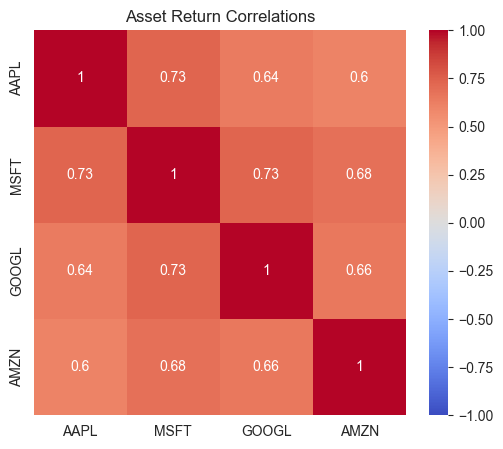

Weighted avg σ:0.0207
Actual portfolio σ:0.0180
Diversification benefit:0.0027


In [24]:
#Correlation & Diversification Benefit
# +1: perfectly correlated
# 0: no correlation
# -1: perfectly inverse correlated

import seaborn as sns
#a) Correlation Heatmap
corr=logR.corr()
plt.figure(figsize=(6,5))
sns.heatmap(corr,annot=True,cmap="coolwarm",vmin=-1,vmax=1) #show actual correlation value ->coolwarm red for positive blue for negative
plt.title('Asset Return Correlations')
plt.show()

#b) Diversification Benefit -> Risk reduction from holding assets together
#gets individual standard deviation of each asset (volatility)

σ_i=logR.std()
σ_weighted=np.dot(weights,σ_i) #computed weighted average standard deviation
σ_portfolio=σ_p #actual potfolio risk
print(f"Weighted avg σ:{σ_weighted:.4f}")
print(f"Actual portfolio σ:{σ_portfolio:.4f}")
print(f"Diversification benefit:{σ_weighted-σ_portfolio:.4f}")

Max Dropdown: -43.98%
From 2021-12-10 to 2023-01-05


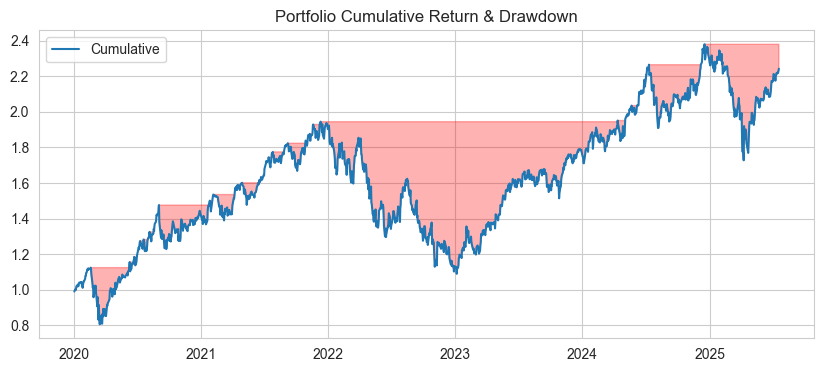

In [25]:
#Max Dropdown
#max. loss from a peak to a valley in portfolio before it recovers(how bad it got before things got better)

cum_ret=(prices/prices.iloc[0]).prod(axis=1) #cumulative portfolio growth?

#Actually for portfolio: cum_port=(portR+1).cumprod()
#converts daily return into cumulative return
#.cumprod() : fives cumulative product like compound interest

cum_port=(portR+1).cumprod()

rolling_max=cum_port.cummax() #compute higher value
drawdown=(cum_port - rolling_max)/rolling_max #measure how far belowe the current value is from peak

max_dd=drawdown.min() #measure the worst(deepest) dip
end_date=drawdown.idxmin() #trough(valley) of max drawdown
start_date=cum_port[:end_date].idxmax() #peak before fall

print(f"Max Dropdown: {max_dd:.2%}")
print(f"From {start_date.date()} to {end_date.date()}")

#Plot
plt.figure(figsize=(10,4))
plt.plot(cum_port,label='Cumulative')
plt.fill_between(drawdown.index,cum_port,rolling_max,where=drawdown<0,color='red',alpha=0.3)
plt.title('Portfolio Cumulative Return & Drawdown')
plt.legend()
plt.show()

In [26]:
#9. Expected Shortfall (CVaR at 95%)
# np.percentile(portR, 5) finds the 5th percentile return.
# portR <= that filters all days in the worst 5%.
# .mean() computes the average loss on those days.
# - sign makes it a positive loss value (convention for risk metrics).
#CVaR -> if you fall into the worst 5% how bad is the average loss

alpha=0.05

#Historical ES
es_hist=-portR[portR <= np.percentile(portR,5)].mean()
#Parametric ES under Normal: μ+σ*ω(z)/α
es_norm=-(μ_p - σ_p * stats.norm.pdf(z05)/alpha)

print(f"Historical ES (95%): {es_hist:.5f}")
print(f"Parametric Normal ES (95%): {es_norm:.5f}")


Historical ES (95%): 0.04192
Parametric Normal ES (95%): 0.03632


In [27]:
#10 VaR Backtesting -> to validate your value at risk model
# VaR_norm	Constant 1-day 95% parametric VaR
# exceptions	Days where actual return < -VaR
# num_exc	How many times VaR was violated
# total	Total days tested
# % exceptions	Should be close to 5% for 95% VaR

var_series=-(portR.rolling(1).mean()+portR.rolling(1).std()*z05)
#for simplicity use constant VaR_norm
exceptions=portR<-VaR_norm
num_exc=exceptions.sum()
total=len(portR)
print(f"Exceptions: {num_exc}/{total} days ({num_exc/total:.2%},expected 5%)")

Exceptions: 70/1392 days (5.03%,expected 5%)


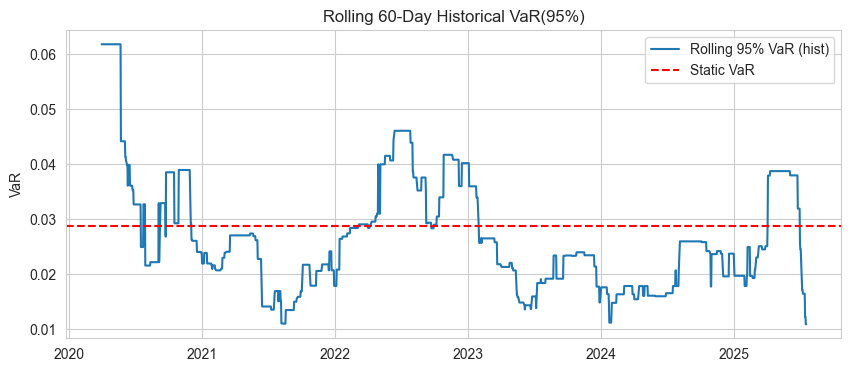

In [28]:
#11. Rolling 60-day VaR
# Instead of computing a single VaR, you compute a new VaR every day based on the previous 60 days of returns.
# This captures how market volatility changes, and helps track dynamic risk.


# portR.rolling(window):Creates a moving window of 60 days over your portfolio returns.
# .quantile(0.05):Calculates the 5th percentile return in each 60-day window = historical VaR (95%).
# .dropna():Removes the first 59 rows where the rolling window is incomplete.


window=60
roll_var=portR.rolling(window).quantile(0.05).dropna()
plt.figure(figsize=(10,4))
plt.plot(-roll_var,label='Rolling 95% VaR (hist)')
plt.axhline(VaR_norm,color='red',linestyle='--',label='Static VaR')
plt.title('Rolling 60-Day Historical VaR(95%)')
plt.ylabel('VaR')
plt.legend()
plt.show()

In [29]:
#12. Jarque-Bera Normality Test
# jb_stat	Jarque-Bera test statistic
# jb_p	p-value for the test
# p < 0.05	Reject normality → returns are not normal
# p ≥ 0.05	Cannot reject → returns may be normal


jb_stat,jb_p=stats.jarque_bera(portR)
print(f"JB statistic={jb_stat:.2f},p-value={jb_p:.3f}")
if jb_p<0.05:
    print("Reject normality at 5% level.")
else:
    print("Cannot reject normality")

JB statistic=1291.97,p-value=0.000
Reject normality at 5% level.
